### CDS NYU
### DS-GA 3001 | Reinforcement Learning
### Lab 06
### March 06, 2025


# Implement RL algorithms with Keras-RL or Stable-Baseline

<br>

---

## Section Leader


Akshitha Kumbam – ak11071@nyu.edu

Kushagra Khatwani – kk5395@nyu.edu


## Goal of Today's Lab 

In this Lab, we will implement RL algorithms by building on existing RL algorithm libraries, so we don't have to implement RL agents from scratch as we did in the past few weeks. By doing so, we get less control on the details of the implementation, but it is much faster to implement (**we will cover 4 case studies today:** `CartPole`, `SpaceInvaders`, `CarRacing`, and `StockTrading`), and components available in public libraries tend to be high quality and efficient. 

Let us start with the DQN algorithm. We can use external open-source Python packages which implement each of the key DQN methods (e,g., experience replay method, action-selection method, etc). These methods are developed, maintained, and optimized for robustness to different scenarios, and for overall performance.

Using these packages instead of implementing each DQN component from scratch is generally faster, leads to a more reliable/efficient program, yet still gives you a lot of control on the details of the implementation and hyperparameters.

We will focus on DQN in the first part of the lab, but these packages also offer methods for most commonly used RL algorithms such as A3C, PPO, etc, so we will start looking at these too.

## Resources

* https://gymnasium.farama.org/


# 1. Implement DQN with Keras-RL methods

---------


# 1.1 Solve *Cart Pole*  with DQN from Keras-rl

Most of this case study will be the same as in previous lab, but we build some of the key components of the DQN agent using components available in the Keral-RL library

## Imports

In [1]:
import time 
import gym
from pyglet.window import key 
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense  
from tensorflow.keras.layers import Activation 
from tensorflow.keras.layers import Flatten  
from tensorflow.keras.optimizers.legacy import Adam  # Adam optimizer

# Import DQN methods from the keras-rl2 library (keras-rl is tagged "rl" in Python)
# Quick fix if python cannot import name '__version__' from 'tensorflow.keras'
import tensorflow as tf
from keras import __version__
tf.keras.__version__ = __version__

from rl.agents.dqn import DQNAgent 

2025-03-10 14:47:02.378681: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Set up the `CartPole` Gym environment

In [2]:
# https://stackoverflow.com/questions/56904270/difference-between-openai-gym-environments-cartpole-v0-and-cartpole-v1
env_name = ENV_NAME = 'CartPole-v1'
env = gym.make(env_name)  

# Same as last week:
num_actions = env.action_space.n
num_observations = env.observation_space.shape[0]
print(f"There are {num_actions} possible actions and {num_observations} observations")


There are 2 possible actions and 4 observations


## Execute random actions just to get familiar with the environment

In [32]:
# Load the CartPole Gym environment with graphical rendering to vizualize the environment
env_test = gym.make("CartPole-v1", render_mode = "human")  # [Jeremy] was v1 last week  
# Set to initial state
env_test.reset()
  

# Loop over 200 steps
for _ in range(200):
    env_test.render()                                                 # Render on the screen
    action = env_test.action_space.sample()                           # Choose a random action
    new_state, reward, done, trunc, info = env_test.step(action)  # Carry out the action
    time.sleep(0.03)
    if done:
         env_test.reset()
            
env_test.close()


## Implement an Artificial Neural Network
To build our network, we first need to find out how many actions and observation our environment has.
We can either get those information from the source code (https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py) or via the following commands:

Similar to in the previous lab, we build a simple ANN with 2 hidden layers and 16 and 32 neurons each followed by relu activation. The output layer has 2 nodes, one for each action

In [3]:
model = Sequential()
# https://keras.io/api/layers/reshaping_layers/flatten/
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))

model.add(Dense(16))
model.add(Activation('relu'))

model.add(Dense(32))
model.add(Activation('relu'))

model.add(Dense(num_actions))
model.add(Activation('linear'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 16)                80        
                                                                 
 activation (Activation)     (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 activation_1 (Activation)   (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
 activation_2 (Activation)   (None, 2)                 0

## Implement the DQN framework with Keras-RL

The DQN agent `DQNagent` from Keras-RL takes the following parameters:

1. `model` = The ANN


2. `nb_actions` = The number of actions (2 in this case)


3. `memory` = The action replay memory. Ny far the most common choice is `SequentialMemory()` 


4. `nb_steps_warmup` = Number of iterations used to fill the memory prior starting to update the ANN parameters


5. `target_model_update` = How often (in number of steps) to update the target model


6. `policy` = You can choose between `LinearAnnealedPolicy()`, `SoftmaxPolicy()`, `EpsGreedyQPolicy()`, `GreedyQPolicy()`, `GreedyQPolicy()`, `MaxBoltzmannQPolicy()` and `BoltzmannGumbelQPolicy()`. We will use the `LinearAnnealedPolicy` policy, but feel free to try them out and inspect which works best here


There are some more parameters you can pass to the DQN Agent, feel free to explore them on your own.

let's initialize a circular buffer with a limit of 20000 and window length of 1 (window length describes the number of steps stored to define a state)


In [4]:
from rl.memory import SequentialMemory  # Sequential Memory for storing observations (optimized circular buffer)

memory = SequentialMemory(limit=20000, window_length=1)


Then we define the Action Selection Policy: <br />
We use *LinearAnnealedPolicy* in order to perform the epsilon greedy strategy with decaying epsilon. <br />
*LinearAnnealedPolicy* accepts an action selection policy, its maximal and minimal values and a step number in order to create a dynamical policy. <br/>
The smallest value epsilon can reach during training is 0.1.<br />
For testing/evaluation of the trained agent, let's set epsilon to 0.05


In [5]:
# LinearAnnealedPolicy allows to decay the epsilon for the epsilon greedy strategy
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy

policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), 
                              attr='eps',
                              value_max=1.,
                              value_min=.1,
                              value_test=.05,
                              nb_steps=20000) 


Now we create the DQN Agent based on the defined model (**model**), the possible actions (**num_actions**) (left and right in this case), the circular buffer (**memory**), the warmup phase (**10**), how often the target model gets updated (**100**) and the policy (**policy**)


In [6]:
dqn = DQNAgent(model = model, nb_actions = num_actions, memory = memory, nb_steps_warmup = 10,
               target_model_update = 100, policy = policy)



We can now compile the DQN with the Adam optimizer and a learning rate of 0.001.<br />
We log the Mean Absolute Error

In [8]:
# Use learning_rate instead of lr if you get warning
dqn.compile(Adam(learning_rate=1e-3), metrics=['mae']) 

2025-03-10 14:47:44.836624: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2025-03-10 14:47:44.856992: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_2_1/bias/Assign' id:145 op device:{requested: '', assigned: ''} def:{{{node dense_2_1/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_2_1/bias, dense_2_1/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Let's run the training for 20000 steps. You can change visualize=True if you want to watch your model learning.
Keep in mind that this increases the running time.


## Train the DQN agent

In [9]:
dqn.fit(env, nb_steps=20000, visualize=False, verbose=2)

Training for 20000 steps ...


/opt/anaconda3/envs/py39_keras_rl/lib/python3.9/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-03-10 14:47:46.074277: W tensorflow/c/c_api.cc:305] Operation '{name:'activation_2/activation_2/Identity' id:76 op device:{requested: '', assigned: ''} def:{{{node activation_2/activation_2/Identity}} = Identity[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_2/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-03-10 14:47:46.093240: W tensorflow/c/c_api.cc:305] Operation '{name:'count_3/Assign' id:268 op device:{requested: '', assigned: ''} def:{{{node count_3/Assign}} = AssignVariableOp[_has_manual_control_de

    26/20000: episode: 1, duration: 0.464s, episode steps:  26, steps per second:  56, episode reward: 26.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.538 [0.000, 1.000],  loss: 0.512875, mae: 0.529912, mean_q: 0.053044, mean_eps: 0.999190
    55/20000: episode: 2, duration: 0.123s, episode steps:  29, steps per second: 235, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.414 [0.000, 1.000],  loss: 0.341856, mae: 0.512733, mean_q: 0.231258, mean_eps: 0.998200
    64/20000: episode: 3, duration: 0.038s, episode steps:   9, steps per second: 237, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.111 [0.000, 1.000],  loss: 0.177482, mae: 0.506869, mean_q: 0.479997, mean_eps: 0.997345


/opt/anaconda3/envs/py39_keras_rl/lib/python3.9/site-packages/rl/memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


    97/20000: episode: 4, duration: 0.187s, episode steps:  33, steps per second: 177, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.485 [0.000, 1.000],  loss: 0.061310, mae: 0.548144, mean_q: 0.831336, mean_eps: 0.996400
   106/20000: episode: 5, duration: 0.042s, episode steps:   9, steps per second: 216, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.778 [0.000, 1.000],  loss: 0.289286, mae: 0.845300, mean_q: 1.081209, mean_eps: 0.995455
   133/20000: episode: 6, duration: 0.109s, episode steps:  27, steps per second: 247, episode reward: 27.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.556 [0.000, 1.000],  loss: 0.187972, mae: 1.133041, mean_q: 1.791945, mean_eps: 0.994645
   158/20000: episode: 7, duration: 0.107s, episode steps:  25, steps per second: 233, episode reward: 25.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.400 [0.000, 1.000],  loss: 0.103561, mae: 1.143291, mean_q: 2.128286, mean_ep

After just 1-2 minutes of training (for reference, it takes < 1min on a Macbook Air with M2), we achieve some great results already. It was taking at least 15 minutes of training to reach a similar level of performance with the custom DQN implemented from scratch in the previous lab.

The reason for this is that keras-rl has implemented many optimization strategies (e.g., the optimized replay buffer) which lead to a significantly faster convergence than the DQN we implemented by hand.

In [ ]:
# After training is done, we can save the final weights.
dqn.save_weights(f'dqn_{env_name}_weights.h5f', overwrite=True)

## Exploit learned Q values in test simulations

The Keras-RL agents also offer methods to perform tests in Gym, with some parameters e.g. to decide whether to render the simulation graphically.

In [10]:
# Finally, evaluate our algorithm for 5 episodes.
dqn.test(env, nb_episodes=5, visualize=True)
env.close()

Testing for 5 episodes ...
Episode 1: reward: 306.000, steps: 306
Episode 2: reward: 290.000, steps: 290
Episode 3: reward: 413.000, steps: 413
Episode 4: reward: 256.000, steps: 256
Episode 5: reward: 282.000, steps: 282


All in all, we accomplished a better agent (trained more efficiently) with much less code than in the previous lab, thanks to Keras-RL!

---------

# 1.2 Solve *Space Invaders*  with Convolutional DQN from Keras-rl

## Imports

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.optimizers.legacy import Adam

# Quick fix if python cannot import name '__version__' from 'tensorflow.keras'
import tensorflow as tf
from keras import __version__
tf.keras.__version__ = __version__

from rl.agents import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy

import gym
env = gym.make('SpaceInvaders-v0')


DependencyNotInstalled: No module named 'atari_py'. (HINT: you can install Atari dependencies by running 'pip install gym[atari]'.)

: 

## Execute random actions just to get familiar with the environment

In [ ]:
# env = gym.make('SpaceInvaders-v0', render_mode='human')

# episodes = 2

# for episode in range(1, episodes):
#     state = env.reset()
#     done = False
#     score = 0
    
#     while not done:
#         #env.render()
#         state, reward, done, trunc, info = env.step(env.action_space.sample())
#         print(state.shape)
#         score += reward
#     print('Episode: {}\nScore: {}'.format(episode, score))
    
# env.close()

## Implement a Convolutional Neural Network

In [ ]:
def build_model(height, width, channels, actions):
    model = Sequential()
    model.add(Conv2D(32, (8,8), strides=(4,4), activation='relu', input_shape=(3, height, width, channels)))
    model.add(Conv2D(64, (4,4), strides=(2,2), activation='relu'))
    model.add(Conv2D(64, (4,4), strides=(2,2), activation='relu'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [ ]:
height, width, channels = env.observation_space.shape
actions = env.action_space.n
print(height, width, channels)

In [ ]:
#del model # [Jeremy] why do we need this? TBD

In [ ]:
model = build_model(height, width, channels, actions)

## Implement the DQN framework 

In [ ]:
def build_agent(model, actions):
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.2, nb_steps=10000)
    memory = SequentialMemory(limit=2000, window_length=3)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  enable_dueling_network=False, dueling_type='avg',
                  nb_actions=actions, nb_steps_warmup=1000)
    return dqn

In [ ]:
dqn = build_agent(model, actions)

In [ ]:
dqn.compile(Adam(learning_rate=0.001))

In [ ]:
dqn.fit(env, nb_steps = 40000, visualize = False, verbose = 1) # Train for 1000 steps in class, try 40000 at home :)

In [ ]:
#dqn.save_weights('SpaceInvaderTrainedModel/dqn.h5f')

## Exploit learned Q values in test simulations

In [ ]:
#dqn.load_weights('SpaceInvaderTrainedModel/dqn.h5f')

In [ ]:
env = gym.make('SpaceInvaders-v0', render_mode = 'human') # Added because with visualize = True it crashes with message that render-'human' is obsolete

scores = dqn.test(env, nb_episodes = 10, visualize = False)  # Would need play with versioning to use the vizualize parameter (currently fixed with line above)
print(np.mean(scores.history['episode_reward']))

# 2. Implement DQN with Stable-baselines algorithms

Instead of implementing DQN from scratch (previous lab), or its individual components from external packages as seen in the section above, yet other packages exist which offer a "complete" implementation of the most popular RL algorithms (DQN, A3C, PPO, DDPG, etc).

Many such packages exist. The most popular ones include OpenAI `Stable-baselines`, DeepMind `Acme`, AWS `SageMaker RL`, Meta `AI ReAgent`, Ray `RLlib`, Intel `AI Coach`. 

Today we will focus exclusively on `Stable-baselines` because it was initially designed by OpenAI in tandem with `Gym` environments. In the final labs of the semester will introduce several other frameworks.


These implementations of RL algorithms have been optimized for ease-of-use, robustness to different scenarios, and overall performance. Their drawback is you get less control on details of the implementation and hyperparameters, compared to using packages such as `Keras-RL` which only implement key *components* of RL algorithms.


# 2.1 Play 'Car Racing' with Convolutional PPO from Stable-baselines

## Imports

In [3]:
import gymnasium as gym

#Quick fix for M1 architecture (M2/M3 might also need this).
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

from stable_baselines3 import PPO 
from stable_baselines3.common.evaluation import evaluate_policy

## Set up the `CarRacing` Gym environment

In [5]:
env = gym.make('CarRacing-v3')
env.observation_space.sample().shape
env.action_space.sample()
#env.reset()
#env.render()
env.close()

## Execute random actions just to get familiar with the environment

In [ ]:
env_test = gym.make('CarRacing-v3', render_mode = 'human')
episodes = 5
for episode in range(episodes):
    state, info = env_test.reset()
    done = False
    score = 0
    
    while not done:
        env_test.render()
        action = env_test.action_space.sample()
        n_state, reward, done, trunc, info = env_test.step(action)
        score+=reward
    print("Episode: {} Score: {}".format(episode, score))
    
env.close()

KeyboardInterrupt: 

: 

In [50]:
# from stable_baselines3.common.env_util import make_vec_env
# env = make_vec_env(lambda: gym.make('CarRacing-v3'), n_envs=1)

## Train the `PPO` algorithm from `stable-baselines`

In [6]:
# model = # FILL
model = PPO("CnnPolicy", env, verbose=1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [1]:
# Train the model
# TODO
model.learn(total_timesteps=1000)


NameError: name 'model' is not defined

## Exploit the trained agent in test simulations

In [ ]:
# Evaluate the policy
# TODO
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=5)
print(f"Mean reward: {mean_reward} +/- {std_reward}")

In [7]:
env.close()

# 2.2 Trade a S&P 500 stock index with DQN from Stable-baselines


In [1]:
import gymnasium as gym

#Quick fix for M1 architecture (M2/M3 might also need this).
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

from stable_baselines3.common.vec_env import DummyVecEnv 
from stable_baselines3 import A2C 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For this case study please install the following libraries: gym_anytrading, yfinance, pandas_datareader, TA
import gym_anytrading
from gym_anytrading.envs import StocksEnv
import yfinance as yf
from pandas_datareader import data as pdr
# yf.pdr_override() # bug fix, for details see https://stackoverflow.com/questions/74862453/why-am-i-getting-a-typeerror-string-indices-must-be-integer-message-when-tryi
from ta import add_all_ta_features # Method from TA (Technical Analysis) library to engineer financial indicators


2025-03-13 18:34:12.073943: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Set up the S&P 500 stock index trading environment

Read some daily time series stock data

In [2]:
df = yf.download('SPY', start='2021-01-01', end='2023-01-01', multi_level_index=False)
df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2021-01-04,348.299408,354.589370,344.549987,354.457135,110210800
2021-01-05,350.698273,351.803278,347.600516,347.647755,66426200
2021-01-06,352.794922,356.034367,348.611067,349.168282,107997700
2021-01-07,358.036499,358.792038,355.023739,355.203185,68766800
2021-01-08,360.076477,360.293679,356.147611,359.443691,71677200


In [3]:
df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date", inplace = True)
df = df.reset_index()
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
df.head()

,Date,Open,High,Low,Close,Volume
0,2021-01-04,354.457135,354.589370,344.549987,348.299408,110210800
1,2021-01-05,347.647755,351.803278,347.600516,350.698273,66426200
2,2021-01-06,349.168282,356.034367,348.611067,352.794922,107997700
3,2021-01-07,355.203185,358.792038,355.023739,358.036499,68766800
4,2021-01-08,359.443691,360.293679,356.147611,360.076477,71677200


Set up the Gym trading environment

In [4]:
env = gym.make('stocks-v0', df=df, frame_bound=(5, 400), window_size=5)

In [5]:
env.action_space

Discrete(2)

## Execute random actions just to get familiar with the environment

Step: 0, Action: 1, Reward: 0, Done: False
Step: 1, Action: 1, Reward: 0, Done: False
Step: 2, Action: 1, Reward: 0, Done: False
Step: 3, Action: 0, Reward: -2.899444580078125, Done: False
Step: 4, Action: 0, Reward: 0, Done: False
Step: 5, Action: 0, Reward: 0, Done: False
Step: 6, Action: 0, Reward: 0, Done: False
Step: 7, Action: 0, Reward: 0, Done: False
Step: 8, Action: 0, Reward: 0, Done: False
Step: 9, Action: 1, Reward: 0, Done: False
Step: 10, Action: 1, Reward: 0, Done: False
Step: 11, Action: 1, Reward: 0, Done: False
Step: 12, Action: 1, Reward: 0, Done: False
Step: 13, Action: 1, Reward: 0, Done: False
Step: 14, Action: 1, Reward: 0, Done: False
Step: 15, Action: 1, Reward: 0, Done: False
Step: 16, Action: 1, Reward: 0, Done: False
Step: 17, Action: 1, Reward: 0, Done: False
Step: 18, Action: 1, Reward: 0, Done: False
Step: 19, Action: 1, Reward: 0, Done: False
Step: 20, Action: 0, Reward: 5.94049072265625, Done: False
Step: 21, Action: 1, Reward: 0, Done: False
Step: 22, 

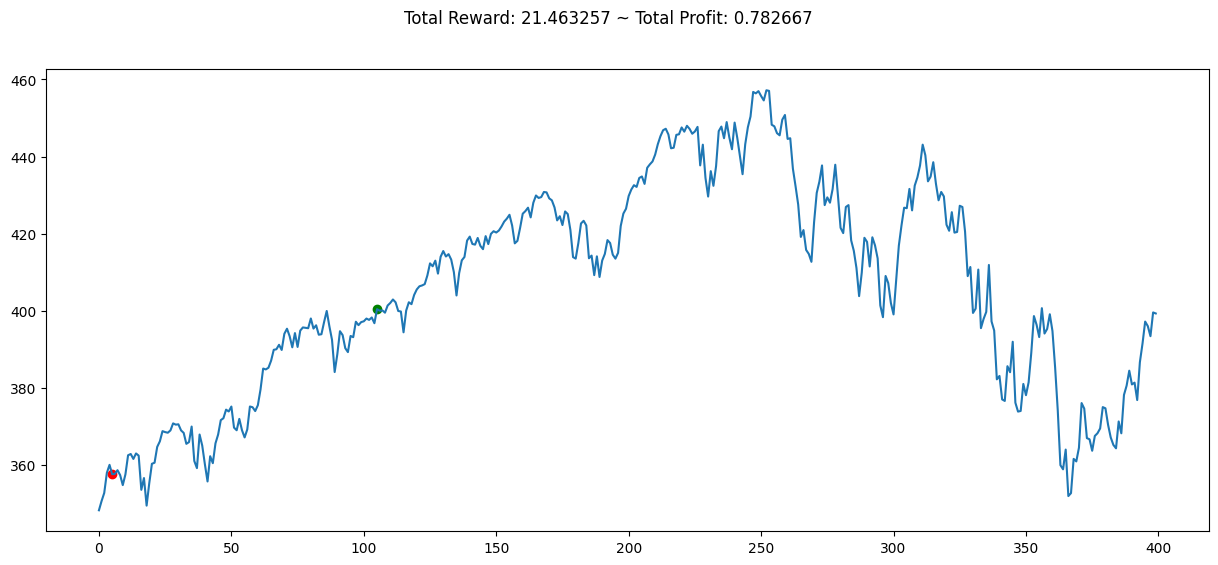

In [6]:

state, info = env.reset()

# Run the environment with random actions (Buy or Sell)
for step in range(100):  # Example: run for 100 steps
    action = env.action_space.sample()  # Sample random action (0 or 1)
    next_state, reward, done, trunc, info = env.step(action)  # Take the action
    
    # Print the action and reward
    print(f"Step: {step}, Action: {action}, Reward: {reward}, Done: {done}")
    
    if done:
        print("Episode finished. Info:", info)
        break

plt.figure(figsize=(15, 6))
plt.cla()
env.render()  # Render the environment
plt.show()

# Close the environment
env.close()

plt.show()


The green dots represent buying while the red dots represent selling stocks.

## Train an `A2C` algorithm from `stable-baselines`

In [100]:
env = gym.make('stocks-v0', df=df, frame_bound=(5, 400), window_size=5)
model = A2C('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 12.5     |
| time/                 |          |
|    fps                | 918      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.69    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.975   |
|    value_loss         | 2.44     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 39.3     |
| time/                 |          |
|    fps                | 823      |
|    iterations         | 200      |
|    time_elapsed 

## Exploit the trained agent in test simulations

In [112]:
env = gym.make('stocks-v0', df=df, frame_bound=(400, 502), window_size=5)
obs, info = env.reset()
for _ in range(100):
    # obs = obs[np.newaxis, ...]
    action, states = model.predict(obs)
    obs, rewards, done,trunc,  info = env.step(action)
    
    if done:
        print(info)
        break

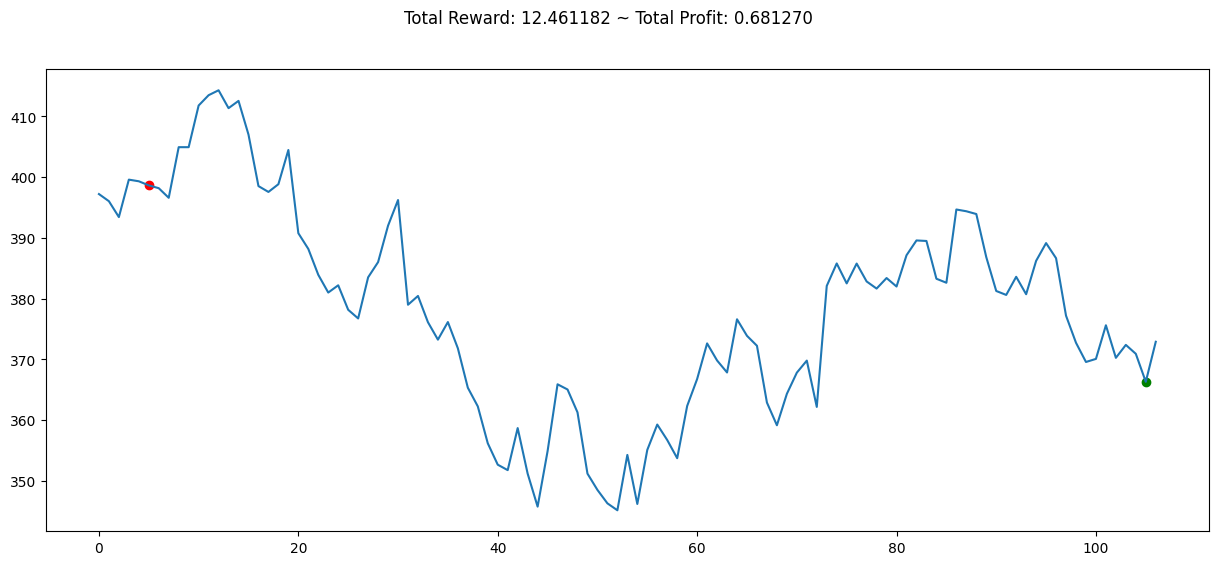

In [ ]:
plt.figure(figsize=(15, 6))
plt.cla()
env.render()
plt.show()

Again, the green dots represent buying while the red dots represent selling stocks. If the agent is capable of making intelligent trading decisions, it will tend to buy (green dots) when the price is relatively low, and to sell (red dots) when the price is relatively high. 

As you can see, the agent needs fine tuning to perform well. So to close the lab, let us fine tune the agent by engineering features ("financial indicators") and adding these additional indicators to the definition of the RL state, so the agent has additional information every day to make trading decisions.

## Engineer features (financial indicators) for the agent to make smarter decisions

In [ ]:
data = pdr.get_data_yahoo('SPY', start='2021-01-01', end='2023-01-01')
# Engineer financial indicators using the method imported above from the "TA" library
df2 = add_all_ta_features(data, open='Open', high='High', low='Low', close='Close', volume='Volume', fillna=True)

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
df2.head()

In [ ]:
def my_processed_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Close', 'Volume', 'momentum_rsi', 'volume_obv', 'trend_macd_diff']].to_numpy()[start:end]
    return prices, signal_features

class MyCustomEnv(StocksEnv):
    _process_data = my_processed_data
    

In [ ]:
env2 = MyCustomEnv(df=df2, window_size= 5, frame_bound=(5, 400))

## Re-train the `A2C` algorithm from `stable-baselines` with the new engineered features

In [ ]:
model = A2C('MlpPolicy', env2, verbose=1)
model.learn(total_timesteps=100000)

## Exploit the trained agent in test simulations

In [ ]:
env = MyCustomEnv(df=df2, window_size=5, frame_bound=(400, 502))
obs = env.reset()

while True:
    obs = obs[np.newaxis, ...]
    action, states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    
    if done:
        print(info)
        break

In [ ]:
plt.figure(figsize=(15, 6))
plt.cla()
env.render_all()
plt.show()

Hopefully you now see more green dots (buy stocks) when the price is relatively low, and more red dots (sell stocks) when the price is relatively high!

**Exercise 1**: What other fine tuning can you try to improve the agent's trading performance?

**Exercise 2**: Implement the `CartPole` and `SpaceInvaders` agents of part 1 of this lab using the DQN algorithms from `stable-baselines`.  

**Exercise 3**: Implement the `PPO` algorithm from `stable-baselines` to learn to play at the `FlappyBird` (lab 5) and `SpaceInvaders` games.

## Thank you everyone!